In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory`
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json


In [2]:
import numpy as np 
import pandas as pd 
import os
import spacy
import matplotlib.pyplot as plt 
import seaborn as sns 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import plotly.express as px
from plotly.offline import init_notebook_mode
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from tqdm import tqdm
nltk.download('omw-1.4')

import tensorflow

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

from datasets import load_dataset


tqdm.pandas()
spacy_eng = spacy.load("en_core_web_sm")
nltk.download('stopwords')
lemm = WordNetLemmatizer()
init_notebook_mode(connected=True)
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 18

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#
headlines_v1 = pd.read_json('../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json', lines=True)
headlines_v2 = pd.read_json('../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json', lines=True)

headlines_v1 = headlines_v1[['headline','is_sarcastic']]
headlines_v2 = headlines_v2[['headline','is_sarcastic']]

headlines = pd.concat([headlines_v1,headlines_v2])
headlines.reset_index(drop=True, inplace=True)

In [4]:
headlines.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [5]:
headlines.info()
# We can see that there are no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55328 entries, 0 to 55327
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      55328 non-null  object
 1   is_sarcastic  55328 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 864.6+ KB


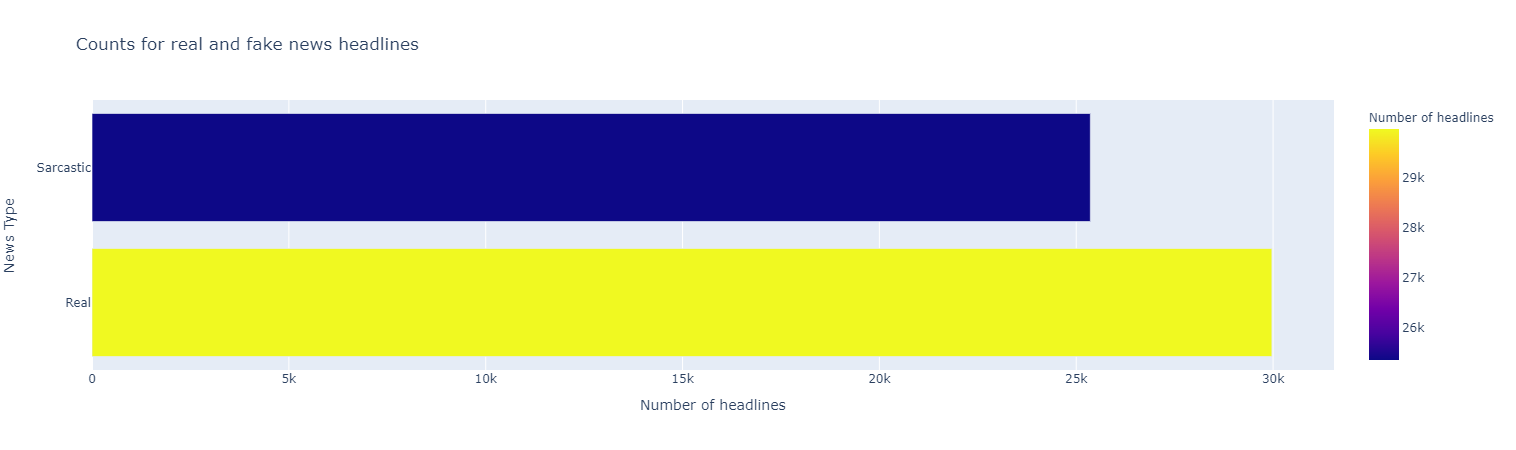

In [6]:
px.bar(headlines.groupby('is_sarcastic').count().reset_index(), 
       x='headline',
       y = ['Real','Sarcastic'],
       title='Counts for real and fake news headlines',
       labels={'headline':'Number of headlines', 'y':'News Type'},
       color = 'headline'
      )

## Data preprocessing

In [7]:
# Let's check the sentence length 
headlines['sen_len_before_pre'] = headlines['headline'].apply(lambda x: len(x.split()))
headlines

,headline,is_sarcastic,sen_len_before_pre
0,former versace store clerk sues over secret 'b...,0,12
1,the 'roseanne' revival catches up to our thorn...,0,14
2,mom starting to fear son's web series closest ...,1,14
3,"boehner just wants wife to listen, not come up...",1,13
4,j.k. rowling wishes snape happy birthday in th...,0,11
...,...,...,...
55323,jews to celebrate rosh hashasha or something,1,7
55324,internal affairs investigator disappointed con...,1,13
55325,the most beautiful acceptance speech this week...,0,12
55326,mars probe destroyed by orbiting spielberg-gat...,1,8


In [8]:
# Data cleaning - Stop words removal, lemmatization, special characters removal

stop_words = stopwords.words('english')
stop_words.remove('not')


def clean_text(sentence):
    
    headline = re.sub('\s+\n+', ' ', sentence)
    headline = re.sub('[^a-zA-Z0-9]', ' ', sentence)
    headline = headline.lower()
    headline = headline.split()
    
    headline = [lemm.lemmatize(word, "v") for word in headline if not word in stop_words]
    headline = ' '.join(headline)
    
    return headline

In [9]:
headlines['clean_headline'] = headlines['headline'].apply(clean_text)

In [10]:
headlines.head()

,headline,is_sarcastic,sen_len_before_pre,clean_headline
0,former versace store clerk sues over secret 'b...,0,12,former versace store clerk sue secret black co...
1,the 'roseanne' revival catches up to our thorn...,0,14,roseanne revival catch thorny political mood b...
2,mom starting to fear son's web series closest ...,1,14,mom start fear son web series closest thing gr...
3,"boehner just wants wife to listen, not come up...",1,13,boehner want wife listen not come alternative ...
4,j.k. rowling wishes snape happy birthday in th...,0,11,j k rowling wish snape happy birthday magical way


In [11]:
headlines['sen_len_after_pre'] = headlines['clean_headline'].apply(lambda x: len(x.split()))
headlines

,headline,is_sarcastic,sen_len_before_pre,clean_headline,sen_len_after_pre
0,former versace store clerk sues over secret 'b...,0,12,former versace store clerk sue secret black co...,10
1,the 'roseanne' revival catches up to our thorn...,0,14,roseanne revival catch thorny political mood b...,8
2,mom starting to fear son's web series closest ...,1,14,mom start fear son web series closest thing gr...,9
3,"boehner just wants wife to listen, not come up...",1,13,boehner want wife listen not come alternative ...,10
4,j.k. rowling wishes snape happy birthday in th...,0,11,j k rowling wish snape happy birthday magical way,9
...,...,...,...,...,...
55323,jews to celebrate rosh hashasha or something,1,7,jews celebrate rosh hashasha something,5
55324,internal affairs investigator disappointed con...,1,13,internal affairs investigator disappoint consp...,8
55325,the most beautiful acceptance speech this week...,0,12,beautiful acceptance speech week come queer ko...,7
55326,mars probe destroyed by orbiting spielberg-gat...,1,8,mar probe destroy orbit spielberg gate space p...,8


In [13]:
# Checking the Named-Entity relationship of sentences to get a detailed view of the content

def entity_detection(x):
    entity = []
    text = spacy_eng(x)
    for word in text.ents:
        entity.append(word.label_)
    return ",".join(entity)

# df.apply(func)
#df.parallel_apply(func)
headlines['entity'] = headlines['clean_headline'].parallel_apply(entity_detection)

In [14]:
headlines

,headline,is_sarcastic,sen_len_before_pre,clean_headline,sen_len_after_pre,entity
0,former versace store clerk sues over secret 'b...,0,12,former versace store clerk sue secret black co...,10,
1,the 'roseanne' revival catches up to our thorn...,0,14,roseanne revival catch thorny political mood b...,8,PERSON
2,mom starting to fear son's web series closest ...,1,14,mom start fear son web series closest thing gr...,9,
3,"boehner just wants wife to listen, not come up...",1,13,boehner want wife listen not come alternative ...,10,
4,j.k. rowling wishes snape happy birthday in th...,0,11,j k rowling wish snape happy birthday magical way,9,PERSON
...,...,...,...,...,...,...
55323,jews to celebrate rosh hashasha or something,1,7,jews celebrate rosh hashasha something,5,
55324,internal affairs investigator disappointed con...,1,13,internal affairs investigator disappoint consp...,8,ORG
55325,the most beautiful acceptance speech this week...,0,12,beautiful acceptance speech week come queer ko...,7,"DATE,NORP"
55326,mars probe destroyed by orbiting spielberg-gat...,1,8,mar probe destroy orbit spielberg gate space p...,8,FAC


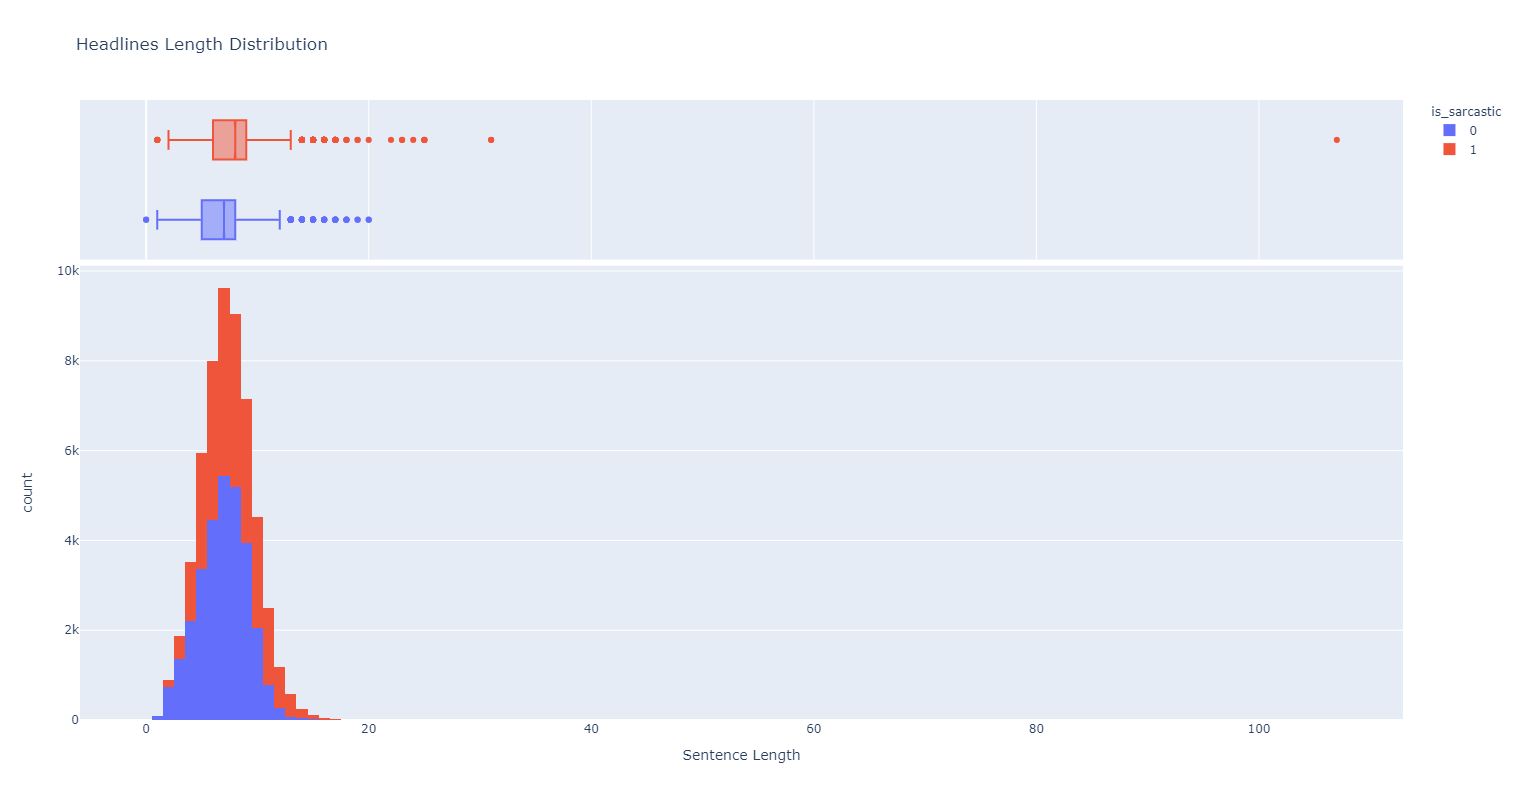

In [15]:
# Sentence length analysis - Looking for outlier length 
px.histogram(headlines, 
             x="sen_len_after_pre",
             height=800,
             color='is_sarcastic', 
             title="Headlines Length Distribution", 
             marginal="box",
             labels={'sen_len_after_pre':'Sentence Length'},
            )

# We see that there are some samples showing outlier nature

In [16]:
headlines[headlines['sen_len_after_pre']> 100]['clean_headline'].iloc[0]

'hot wheel rank number one toy roll ramp knock dominoes send marble funnel drop onto teeter totter yank string cause pulley system raise wooden block propel series twine rollers unwind spring launch tennis ball across room inch tire slope hit power switch activate table fan blow toy ship nail attach across kiddie pool pop water balloon fill cup weigh lever force basketball track nudge broomstick axis rotate allow golf ball roll sideways coffee mug tumble row hardcover book handle catch hook attach lever cause wooden mallet slam serve spoon catapult small ball cup attach ribbon lazy susan spin push battery incline plane tip salt shaker season omelet'

In [17]:
headlines.drop(headlines[headlines['sen_len_after_pre'] > 100].index, inplace = True)
headlines.reset_index(inplace=True, drop=True)

In [18]:
headlines.head()

,headline,is_sarcastic,sen_len_before_pre,clean_headline,sen_len_after_pre,entity
0,former versace store clerk sues over secret 'b...,0,12,former versace store clerk sue secret black co...,10,
1,the 'roseanne' revival catches up to our thorn...,0,14,roseanne revival catch thorny political mood b...,8,PERSON
2,mom starting to fear son's web series closest ...,1,14,mom start fear son web series closest thing gr...,9,
3,"boehner just wants wife to listen, not come up...",1,13,boehner want wife listen not come alternative ...,10,
4,j.k. rowling wishes snape happy birthday in th...,0,11,j k rowling wish snape happy birthday magical way,9,PERSON


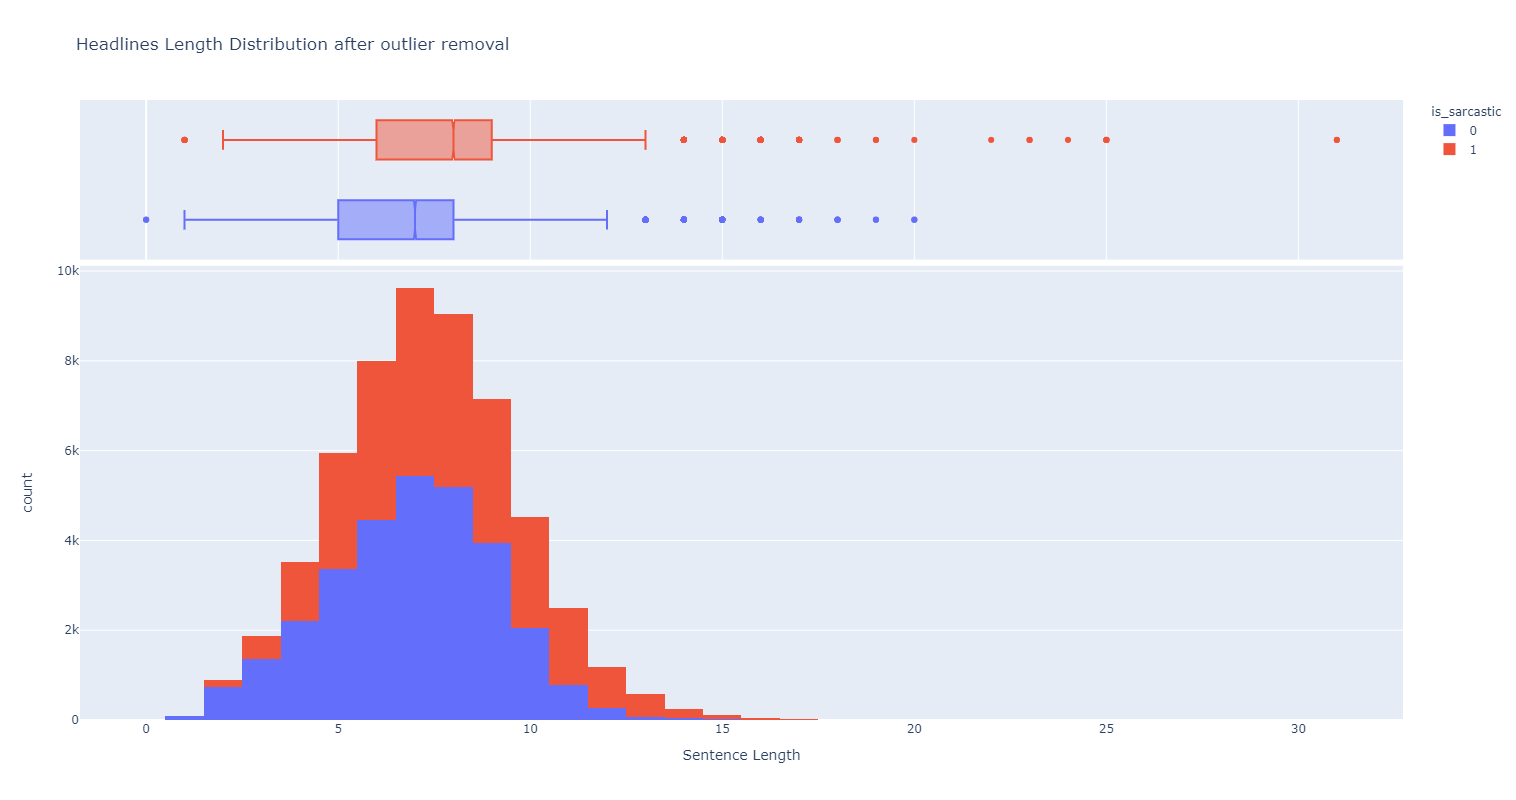

In [19]:
px.histogram(headlines, 
             x="sen_len_after_pre",
             height=800,
             color='is_sarcastic', 
             title="Headlines Length Distribution after outlier removal", 
             marginal="box",
             labels={'sen_len_after_pre':'Sentence Length'},
            )


## Word Clouds

In [20]:
sarcastic = headlines[headlines['is_sarcastic']==1]['clean_headline'].tolist()
real = headlines[headlines['is_sarcastic']==0]['clean_headline'].tolist()

### Top 100 Sarcastic words

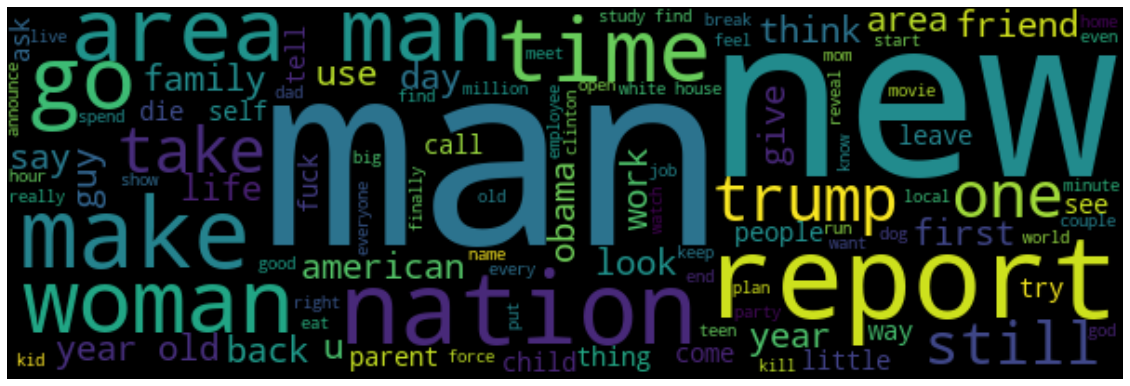

In [21]:
wordcloud = WordCloud(max_words=100, width=600, background_color='black').generate(" ".join(sarcastic))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Top 100 real words

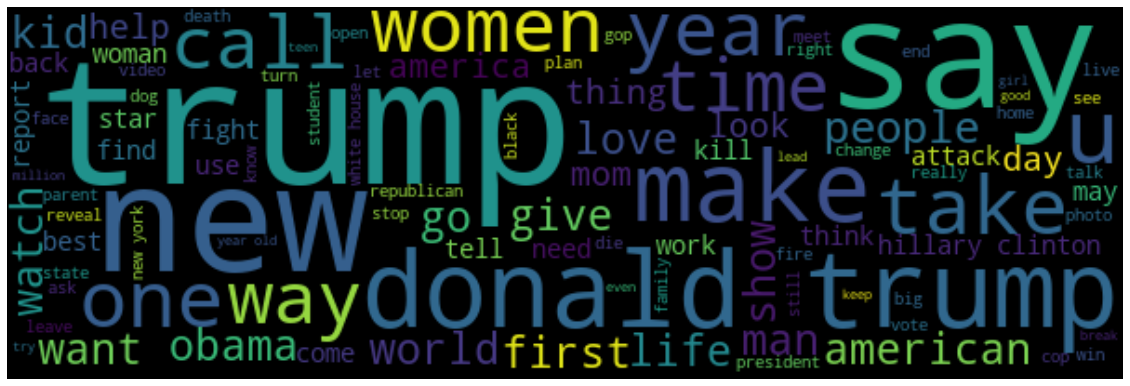

In [22]:
wordcloud = WordCloud(max_words=100, width=600, background_color='black').generate(" ".join(real))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Model Building

## Firstly we will build a traditional machine learning algorithm which does not support attention mechanism like multinomial naive bayes classifier and random forests

## Multinomial Naive Bayes Classifier

In [21]:
# TODO: Write code here to train and evaluate a Multinomial Naive Bayes classifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


X = headlines.clean_headline
y  = headlines.is_sarcastic

# split the dataset for training and testing for random forest algo
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=21
)


pipeline = Pipeline([("count_vector",CountVectorizer()), ("tfidf_transformer",TfidfTransformer()), ("nb_classifier",MultinomialNB())])

pipeline.fit(X_train, y_train)

pred_test = pipeline.predict(X_test)

print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      8989
           1       0.86      0.79      0.82      7610

    accuracy                           0.84     16599
   macro avg       0.85      0.84      0.84     16599
weighted avg       0.84      0.84      0.84     16599



In [22]:
pd.DataFrame(classification_report(y_test, pred_test, output_dict=True)).T

,precision,recall,f1-score,support
0,0.830642,0.892647,0.860529,8989.000000
1,0.860931,0.785020,0.821225,7610.000000
accuracy,0.843304,0.843304,0.843304,0.843304
macro avg,0.845786,0.838833,0.840877,16599.000000
weighted avg,0.844528,0.843304,0.842509,16599.000000


In [23]:
vectorizer = TfidfVectorizer()

X = headlines.clean_headline
y  = headlines.is_sarcastic

X_tfidf = vectorizer.fit_transform(X)


# split the dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.3, random_state=42
)


# Create a base model
rf = RandomForestClassifier()


# Fit the model to the data
rf.fit(X_train, y_train)

# Predict the response for test dataset
y_pred_RF = rf.predict(X_test)



In [24]:
pd.DataFrame(classification_report(y_test, y_pred_RF, output_dict=True)).T

,precision,recall,f1-score,support
0,0.907294,0.951869,0.929047,9017.000000
1,0.939207,0.884331,0.910944,7582.000000
accuracy,0.921019,0.921019,0.921019,0.921019
macro avg,0.923251,0.918100,0.919995,16599.000000
weighted avg,0.921871,0.921019,0.920778,16599.000000


## BERT base uncased

In [28]:
from transformers import AutoTokenizer, BertTokenizerFast
from transformers import BertForSequenceClassification, AdamW
from transformers import Trainer ,TrainingArguments

In [29]:
# model name from huggingface library
model_name = "bert-base-uncased"
# max sequence length for each document/sentence sample
max_length = 512

In [30]:
# load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [31]:
X_train, X_val, y_train, y_val = train_test_split(headlines['clean_headline'] , headlines['is_sarcastic'], test_size=0.2, stratify=headlines['is_sarcastic'], random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val, random_state=42)

In [32]:
print(f'Number of Training samples:{X_train.shape}')
print('\n')
print(f'Number of Validation samples: {X_val.shape}')
print('\n')
print(f'Number of Testing samples: {X_test.shape}')

Number of Training samples:(44261,)


Number of Validation samples: (5533,)


Number of Testing samples: (5533,)


In [33]:
train_labels = y_train.values
valid_labels = y_val.values
test_labels = y_test.values

In [48]:
train_encodings = tokenizer(list(X_train.values), truncation=True, padding=True, max_length=max_length)
val_encodings = tokenizer(list(X_val.values), truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer(list(X_test.values), truncation=True, padding=True, max_length=max_length)
    
print('Train, validation and test sentences encoded')

Train, validation and test sentences encoded


In [49]:
tokenizer.convert_tokens_to_ids(train_encodings)

[100, 100, 100]

In [42]:
import torch

class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)


# convert our tokenized data into a torch Dataset
train_dataset = NewsDataset(train_encodings, train_labels)
valid_dataset = NewsDataset(val_encodings, valid_labels)
test_dataset = NewsDataset(test_encodings, test_labels)

In [41]:
# load the model and pass to CUDA
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2).to("cuda")

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [42]:
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # calculate accuracy using sklearn's function
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
  }

In [43]:
import wandb
#wandb login

In [44]:

#wandb.init(project="fake-news-detection", entity="maytheforcebewithyou")

In [45]:
training_args = TrainingArguments(
    output_dir='./',          # output directory
    num_train_epochs=10,                    # total number of training epochs
    per_device_train_batch_size=32,          # batch size per device during training
    per_device_eval_batch_size=32,           # batch size for evaluation
    warmup_steps=500,                       # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                      # strength of weight decay    
    load_best_model_at_end=True,            # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=10000,                      # log & save weights each logging_steps
    save_steps=10000,
    evaluation_strategy="steps",            # evaluate each `logging_steps`
    #report_to="wandb"
)

In [46]:
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

In [47]:
os.environ["WANDB_DISABLED"] = "true"
trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning

***** Running training *****
  Num examples = 44261
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 13840
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Step,Training Loss,Validation Loss,Accuracy
10000,0.090100,0.232710,0.973613


***** Running Evaluation *****
  Num examples = 5533
  Batch size = 32
Saving model checkpoint to ./checkpoint-10000
Configuration saved in ./checkpoint-10000/config.json
Model weights saved in ./checkpoint-10000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./checkpoint-10000 (score: 0.23270970582962036).


TrainOutput(global_step=13840, training_loss=0.06599882565481814, metrics={'train_runtime': 1870.6101, 'train_samples_per_second': 236.613, 'train_steps_per_second': 7.399, 'total_flos': 8188283264968800.0, 'train_loss': 0.06599882565481814, 'epoch': 10.0})

In [48]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 5533
  Batch size = 32


{'eval_loss': 0.23270970582962036,
 'eval_accuracy': 0.973612868245075,
 'eval_runtime': 5.8963,
 'eval_samples_per_second': 938.386,
 'eval_steps_per_second': 29.34,
 'epoch': 10.0}

In [49]:
prediction_test = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 5533
  Batch size = 32


In [50]:
prediction_test = np.argmax(prediction_test.predictions, 1)

In [51]:
y_true = test_labels
y_pred = prediction_test

In [52]:
confusion_matrix(y_true= y_true , y_pred=y_pred)

array([[2923,   74],
       [  66, 2470]])

In [53]:
pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).T

,precision,recall,f1-score,support
0,0.977919,0.975309,0.976612,2997.000000
1,0.970912,0.973975,0.972441,2536.000000
accuracy,0.974697,0.974697,0.974697,0.974697
macro avg,0.974415,0.974642,0.974527,5533.000000
weighted avg,0.974707,0.974697,0.974700,5533.000000


In [54]:

from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, auc


fpr, tpr, thresholds = roc_curve(y_true, prediction_test )

In [55]:
roc_auc_score(y_true , prediction_test )

0.9746417026911243

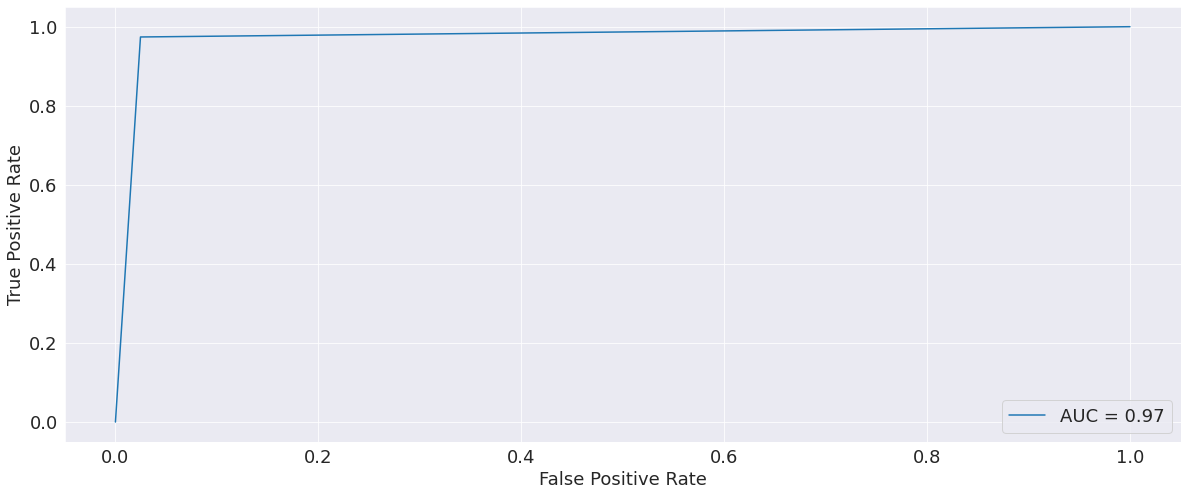

In [56]:
roc_auc = auc(fpr, tpr)
import matplotlib.pyplot as plt
display = RocCurveDisplay(fpr=fpr,tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()

## DISTILBERT base uncased

In [57]:
# model name from huggingface library
model_name = "distilbert-base-uncased"
# max sequence length for each document/sentence sample
max_length = 512

In [58]:
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)

https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpr3817wj9


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
creating metadata file for /root/.cache/huggingface/transformers/8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpxp7o_g6q


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
creating metadata file for /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpct9v1rol


Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
creating metadata file for /root/.cache/huggingface/transformers/75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-uncased/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
creating metadata file for /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.0

In [59]:
train_encodings = tokenizer(list(X_train.values), truncation=True, padding=True, max_length=max_length)
val_encodings = tokenizer(list(X_val.values), truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer(list(X_test.values), truncation=True, padding=True, max_length=max_length)

print('Train, validation and test sentences encoded')

Train, validation and test sentences encoded


In [60]:
# convert our tokenized data into a torch Dataset
train_dataset = NewsDataset(train_encodings, train_labels)
valid_dataset = NewsDataset(val_encodings, valid_labels)
test_dataset = NewsDataset(test_encodings, test_labels)

In [61]:
# load the model and pass to CUDA
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2).to("cuda")

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Model config BertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dim": 768,
  "dropout": 0.1,
  "hidden_act": "gelu",
  "hidden_dim": 3072,
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "n_heads": 12,
  "n_layers": 6,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,


Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
creating metadata file for /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing BertForSequenceClassification: ['distilbert.transformer.layer.1.sa_layer_norm.bias', 'distilbert.transformer.layer.1.attention.k_lin.weight', 'distilbert.transfor

In [62]:
training_args = TrainingArguments(
    output_dir='./',          # output directory
    num_train_epochs=10,                    # total number of training epochs
    per_device_train_batch_size=32,          # batch size per device during training
    per_device_eval_batch_size=32,           # batch size for evaluation
    warmup_steps=500,                       # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                      # strength of weight decay    
    load_best_model_at_end=True,            # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=10000,                      # log & save weights each logging_steps
    save_steps=10000,
    evaluation_strategy="steps",            # evaluate each `logging_steps`
    #report_to="wandb"
)

using `logging_steps` to initialize `eval_steps` to 10000
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [63]:
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

In [64]:
os.environ["WANDB_DISABLED"] = "true"
trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning

***** Running training *****
  Num examples = 44261
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 13840


Step,Training Loss,Validation Loss,Accuracy
10000,0.190200,0.294290,0.944876


***** Running Evaluation *****
  Num examples = 5533
  Batch size = 32
Saving model checkpoint to ./checkpoint-10000
Configuration saved in ./checkpoint-10000/config.json
Model weights saved in ./checkpoint-10000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./checkpoint-10000 (score: 0.2942902445793152).


TrainOutput(global_step=13840, training_loss=0.14571372236130556, metrics={'train_runtime': 1860.8774, 'train_samples_per_second': 237.85, 'train_steps_per_second': 7.437, 'total_flos': 8188283264968800.0, 'train_loss': 0.14571372236130556, 'epoch': 10.0})

In [65]:
prediction_test = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 5533
  Batch size = 32


In [66]:
prediction_test = np.argmax(prediction_test.predictions, 1)

In [67]:
y_true = test_labels
y_pred = prediction_test

In [68]:
confusion_matrix(y_true= y_true , y_pred=y_pred)

array([[2914,   83],
       [ 215, 2321]])

In [69]:
pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).T

,precision,recall,f1-score,support
0,0.931288,0.972306,0.951355,2997.000000
1,0.965474,0.915221,0.939676,2536.000000
accuracy,0.946141,0.946141,0.946141,0.946141
macro avg,0.948381,0.943763,0.945515,5533.000000
weighted avg,0.946957,0.946141,0.946002,5533.000000


In [70]:

from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, auc


fpr, tpr, thresholds = roc_curve(y_true, prediction_test )
roc_auc_score(y_true , prediction_test )

0.94376322958079

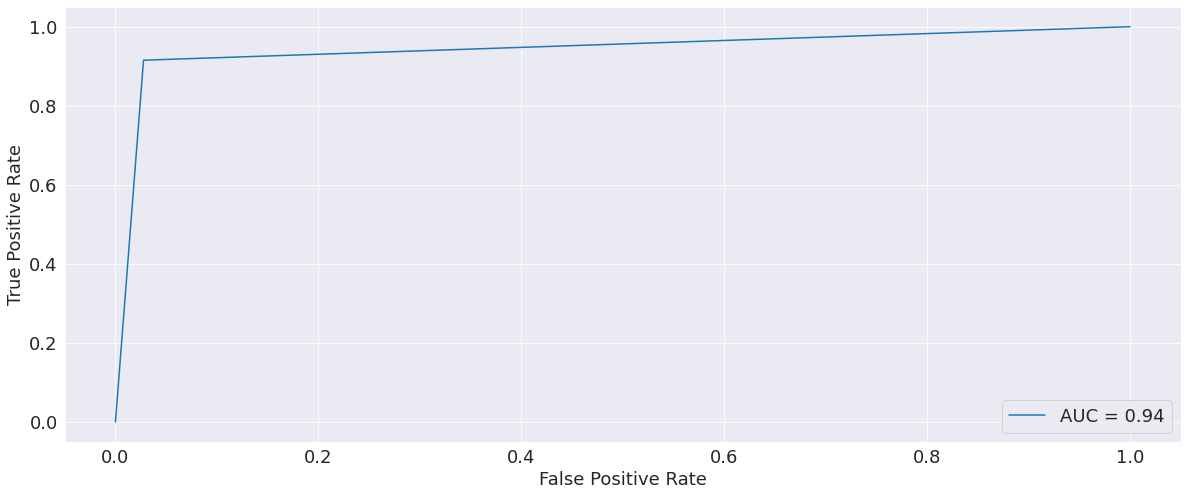

In [71]:
roc_auc = auc(fpr, tpr)
import matplotlib.pyplot as plt
display = RocCurveDisplay(fpr=fpr,tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()